# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter
import re
import pandas as pd
import json
import codecs
import time
from sklearn.feature_extraction import DictVectorizer

CONSUMER_KEY = "9joAHzKIvI1Clc1Vo6ZYiShx2"
CONSUMER_SECRET = "8VuwCPpRjcdbCJCQVHM8VTLf3wVKOVQgRewJRB4apwuLM5cESk"

ACCESS_TOKEN_KEY = "779281502374916097-ilhzLNInIfkcSVorwLievgqINEkK9Qg"
ACCESS_TOKEN_SECRET = "BVMe5MUgS8iYOxASUXYrp5p9xBTN15hj0fPX12Iq0LhA7"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    statuses = api.GetUserTimeline(user_id, count = 200, include_rts=False, exclude_replies=True, trim_user=True)
    result = []
    for status in statuses:
        result.append(status.AsDict())
        
    return result

In [3]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

In [10]:
from os import listdir
from os.path import isfile, join

processed_users = [f for f in listdir("tweets") if isfile(join("tweets", f))]

print len(processed_users)

11168


In [ ]:
import time

count_ok = 0;
count_bad = 0;
count_ex = 0;

for i in df_users["uid"]:
    if str(i) not in processed_users:
        try:
            count_ok += 1
            uid_tweet = get_user_tweets(i)
            with codecs.open(u'tweets/' + str(i), u'w', u'utf-8') as f:
                json.dump(uid_tweet, f)
            f.close()
        except Exception as error:
            print error
            if ("code" in error[0][0] and error[0][0]["code"] == 34) or error.message == "Not authorized.":
                count_bad += 1
            elif ("code" in error[0][0] and error[0][0]["code"] == 88):
                print "wait"
                time.sleep(960)
            continue
    else: 
        count_ex += 1
        
print "downloaded: ", count_ok
print "bad: ", count_bad
print "already downloaded: ", count_ex
        

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def get_words(text):
    """returns list of words"""
    return tokenizer.tokenize(text)

In [35]:
print get_words("Here are different words!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [37]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import nltk

wnl = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [6]:
def get_tokens(words):
    """returns list of tokens"""
    tokens = map(lambda word: wnl.lemmatize(word), words) 
    tokens = [word for word in tokens if word not in stopwords]
    return tokens

In [9]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [7]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [8]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""    
    list_users = []
    list_dict_tokens = []
    list_noise = ['http', 'don\'t', 'i\'m', 'it', 'it\'s', 'amp', 'The', 'This', 'What', 'co', 'I', 'via', 'YouTube', 'You', 'A', 'video', 'wa']
    
    count = 0;
    for uid in df_users.uid:
        count += 1
        if (count % 2000 == 0):
            print count
        uid_tweets = []
        if str(uid) in processed_users:
            with codecs.open(u'tweets/' + str(uid), u'r', u'utf-8') as f:
                uid_tweets = json.loads(f.readline())
        dict_tokens = {}
        for tweet in uid_tweets:
            list_tokens = get_tweet_tokens(tweet["text"])
            for token in list_tokens:
                if token in dict_tokens:
                    dict_tokens[token] =  dict_tokens[token] + 1
                else:
                    if len(token) > 1 and token not in list_noise:
                        dict_tokens[token] = 1
        list_users.append(uid)
        list_dict_tokens.append(dict_tokens)
        
    return list_users, list_dict_tokens

In [11]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

2000
4000
6000
8000
10000


In [12]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [43]:
list_feq = vs.sum(axis = 0)
list_feq = list_feq.tolist()[0]
tokens_feq = zip(v.get_feature_names(), list_feq)

In [44]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def draw_tag_cloud(v, vs):
    mask = np.array(Image.open("files/logo.png"))
    wc = WordCloud(background_color="white", max_words=1000, mask=mask, stopwords=("http"))    
    wc.generate_from_frequencies(tokens_feq)
    wc.to_file("files/result.png")
    
    plt.figure(figsize = (12, 12))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

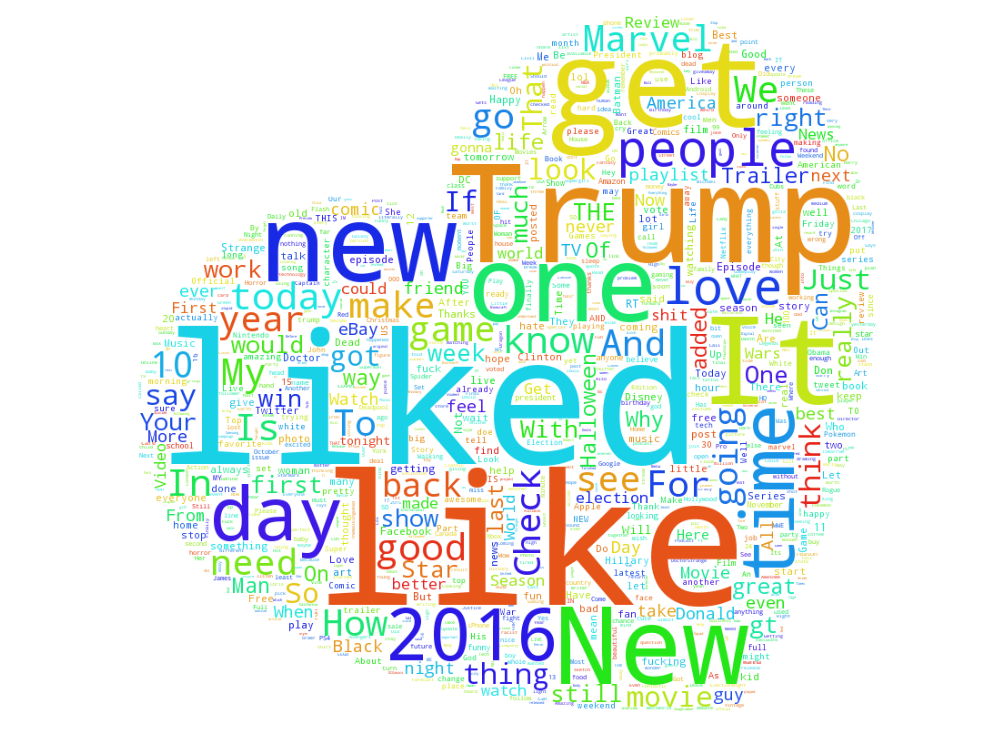

In [45]:
draw_tag_cloud(v, vs)